In [1]:
%run "Common setup.ipynb"

In [2]:
from SALib.analyze.rbd_fast import analyze as rbd_analyze

In [3]:
### Analyze extreme results

extreme_numeric_samples = pd.read_csv(f'{DATA_DIR}extreme_numeric_samples.csv', index_col=0)
extreme_numeric_samples = extreme_numeric_samples[perturbed_cols]
extreme_numeric_vals = extreme_numeric_samples.values


# Results from extremity testing with coupling disabled
extreme_results = pd.read_csv(f'{DATA_DIR}no_irrigation_extreme_results.csv', index_col=0)
extreme_results['Avg. $/ML'].fillna(extreme_results["Avg. Annual Profit ($M)"], inplace=True)

extreme_disabled_res = extreme_results.values
target_result_idx = extreme_results.columns.tolist().index(tgt_metric)

extremity_disabled_results = rbd_analyze(CIM_SPEC, extreme_numeric_vals, 
                                         extreme_disabled_res[:, target_result_idx],   # [:, target_result_idx]
                                         M=4, seed=101)

d:\userdata\takuyai\owncloud\projects\salib-roat\src\SALib\analyze\rbd_fast.py:106: RuntimeWarning: invalid value encountered in double_scalars
  return D1 / V


In [4]:
# Extreme values with interactions
extreme_results = pd.read_csv(f'{DATA_DIR}with_irrigation_extreme_results.csv', index_col=0)
extreme_results['Avg. $/ML'].fillna(extreme_results["Avg. Annual Profit ($M)"], inplace=True)

extreme_enabled_res = extreme_results.values

extremity_enabled_results = rbd_analyze(CIM_SPEC, extreme_numeric_vals, 
                                         extreme_enabled_res[:, target_result_idx],
                                         M=4, seed=101)

# extreme_enabled_results.plot()

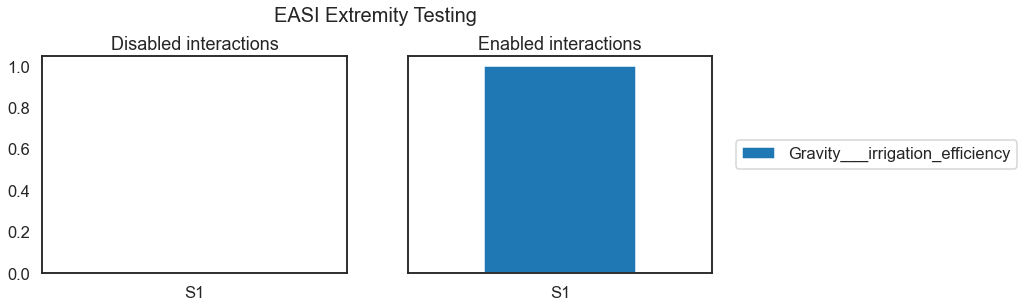

In [5]:
# extremity_disabled_results
# extreme_enabled_results

fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)

disabled = extremity_disabled_results.to_df().loc[tgt_param, ['S1']]
disabled.name = 'Gravity___irrigation_efficiency'

enabled = extremity_enabled_results.to_df().loc[tgt_param, ['S1']]
enabled.name = 'Gravity___irrigation_efficiency'

disabled.plot(kind='bar', 
             legend=None,
             title='Disabled interactions',
             ax=axes[0],
             rot=0)

enabled.plot(kind='bar',
             legend=None,
             title='Enabled interactions',
             ax=axes[1],
             rot=0).legend(
                 bbox_to_anchor=(1.05, 0.65)
             )

fig.suptitle("EASI Extremity Testing", x=0.51, y=1.05, fontsize=20);

In [6]:
fig.savefig(f'{FIG_DIR}single_param_ext_EASI_results.png', dpi=300, bbox_inches='tight')

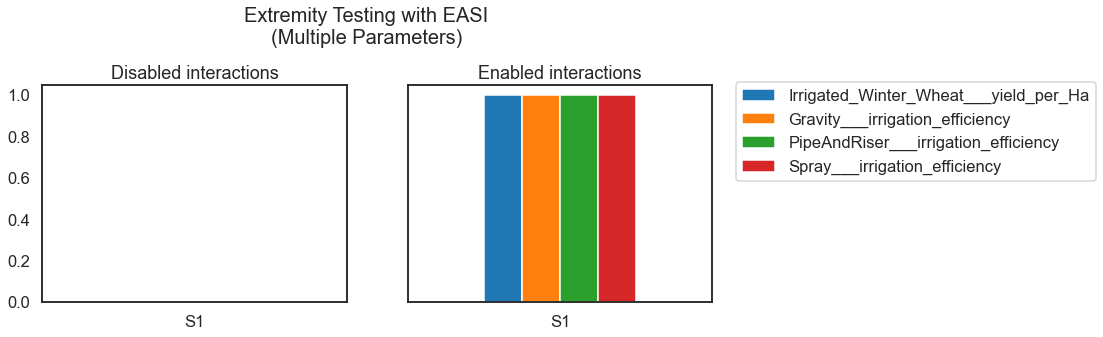

In [7]:
disabled = extremity_disabled_results.to_df()
enabled = extremity_enabled_results.to_df()

selected_idx = [c for c in enabled.index
                 if 'irrigation_eff' in c.lower() or 'irrigated_winter_wheat___yield_per_ha' in c.lower()]

selected_no_ext = disabled.loc[selected_idx, :]
selected_no_ext.index = selected_no_ext.index.str.replace('Farm___Crops___variables___', '')
selected_no_ext.index = selected_no_ext.index.str.replace('Farm___Irrigations___', '')

selected_with_ext = enabled.loc[selected_idx, :]
selected_with_ext.index = selected_with_ext.index.str.replace('Farm___Crops___variables___', '')
selected_with_ext.index = selected_with_ext.index.str.replace('Farm___Irrigations___', '')


fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True)

selected_no_ext.T.plot(kind='bar', legend=None, 
                       title='Disabled interactions',
                       ax=axes[0], 
                       rot=0)

selected_with_ext.T.plot(kind='bar', 
                         legend=None,
                         title='Enabled interactions',
                         rot=0,
                         ax=axes[1]).legend(
                            bbox_to_anchor=(1.05, 1.05)
                         )

fig.suptitle("Extremity Testing with EASI\n(Multiple Parameters)", x=0.5, y=1.15, fontsize=20);
fig.savefig(f'{FIG_DIR}extremity_testing_EASI_multi_param_results.png', dpi=300, bbox_inches='tight')

In [8]:
fig.savefig(f'{FIG_DIR}ext_testing_EASI_all_params_results.png', dpi=300, bbox_inches='tight')

---

In [9]:
def incremental_easi_analysis(lower, upper, step=1):
    res, idx = [], []
    for reps in range(lower, upper, step):
        try:
            results = rbd_analyze(CIM_SPEC, numeric_vals[:reps, :], 
                                           np_res[:reps], 
                                           M=4, seed=101)
        except ZeroDivisionError:
            res.append(np.nan)
            idx.append(reps)
            continue
        # End try

        enabled = results.to_df()
        tmp = enabled.loc[tgt_param, 'S1']
        res.append(tmp)
        idx.append(reps)
    # End for
    
    return res, idx

In [10]:
### With more samples...

numeric_samples = pd.read_csv(f'{DATA_DIR}oat_mc_10_numeric_samples.csv', index_col=0)
numeric_samples = numeric_samples[perturbed_cols]
numeric_vals = numeric_samples.values

In [11]:
# Coupling disabled
oat_10_no_irrigation_results = pd.read_csv(f'{DATA_DIR}oat_no_irrigation_10_results.csv', index_col=0)
oat_10_no_irrigation_results['Avg. $/ML'].fillna(oat_10_no_irrigation_results["Avg. Annual Profit ($M)"], inplace=True)


target_result_idx = oat_10_no_irrigation_results.columns.tolist().index(tgt_metric)
np_res = oat_10_no_irrigation_results.iloc[:, target_result_idx].values

res, idx = incremental_easi_analysis(2, 541)

disabled = pd.DataFrame({'S1': res}, index=idx)

In [12]:
# Coupling enabled

oat_10_with_irrigation_results = pd.read_csv(f'{DATA_DIR}oat_with_irrigation_10_results.csv', index_col=0)
oat_10_with_irrigation_results['Avg. $/ML'].fillna(oat_10_with_irrigation_results["Avg. Annual Profit ($M)"], inplace=True)

np_res = oat_10_with_irrigation_results.values[:, target_result_idx]
np_res = np_res.astype('float64')

res, idx = incremental_easi_analysis(2, 541)

enabled = pd.DataFrame({'S1': res}, index=idx)

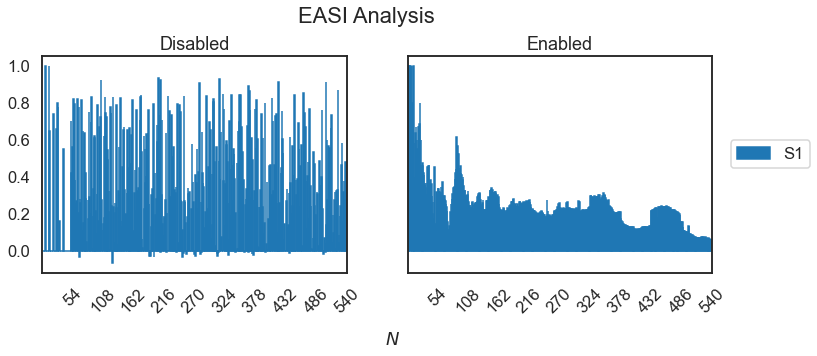

In [13]:
fig, axes = plt.subplots(1,2, figsize=(12,4), sharey=True, sharex=True)

labels = [str(i) if i % 54 == 0 else '' for i in idx]
disabled.loc[:, 'S1'].plot(kind='bar', 
                           legend=None,
                           title='Disabled',
                           ax=axes[0],
                           use_index=False,
                           rot=45,
                           width=1.1,
                           edgecolor='C0')

enabled.loc[:, 'S1'].plot(kind='bar', 
                          legend=None,
                          title='Enabled',
                          ax=axes[1],
                          use_index=False,
                          rot=45,
                          width=1.1,
                          edgecolor='C0').legend(
                             bbox_to_anchor=(1.35, 0.65)
                          )
fig.suptitle("EASI Analysis", x=0.5, y=1.05, fontsize=22)
# fig.tight_layout()
plt.xlabel("$N$", x=-0.05, labelpad=15);

axes[0].set_xticklabels(labels)
axes[1].set_xticklabels(labels);

In [14]:
fig.savefig(FIG_DIR+'EASI_larger_sample.png', dpi=300, bbox_inches='tight')

---

Using full inputs/outputs

In [16]:
target_result_idx = all_outputs.columns.tolist().index("SW Allocation Index")

numeric_samples = to_numeric_samples(all_inputs)
numeric_vals = numeric_samples.values
np_res = all_outputs.values[:, target_result_idx]
np_res = np_res.astype('float64')

In [17]:
res, idx = incremental_easi_analysis(2, 5625)

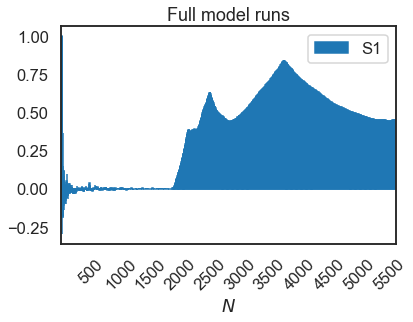

In [18]:
full_run_plot = pd.DataFrame({'S1': res}, index=idx).plot(
                               kind='bar', 
                               # legend=None,
                               title='Full model runs',
                               use_index=False,
                               rot=45,
                               width=1.1,
                               edgecolor='C0')
full_run_plot.set_xlabel("$N$")

labels = [str(i) if i % 500 == 0 else '' for i in idx]

full_run_plot.set_xticklabels(labels)
full_run_plot.set_xticklabels(labels);